<a href="https://colab.research.google.com/github/xtliao/PyTorchProjects/blob/main/nn-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [94]:
# device agnostic code
device = torch.device("cuda") if torch.cuda.is_available else torch.device("cpu")
device

device(type='cuda')

In [95]:
# prep the toy circle data
from sklearn.datasets import make_circles

RANDOM_SEED=37

X, y = make_circles(n_samples=1000, noise=0.03, random_state=RANDOM_SEED)

import pandas as pd

circles = pd.DataFrame({
    "X1": X[:,0],
    "X2": X[:,1],
    "label": y
})

circles.head()

,X1,X2,label
0,0.792846,-0.162791,1
1,-0.571136,0.488523,1
2,1.022558,0.115237,0
3,0.199532,0.796366,1
4,-0.268985,0.731217,1


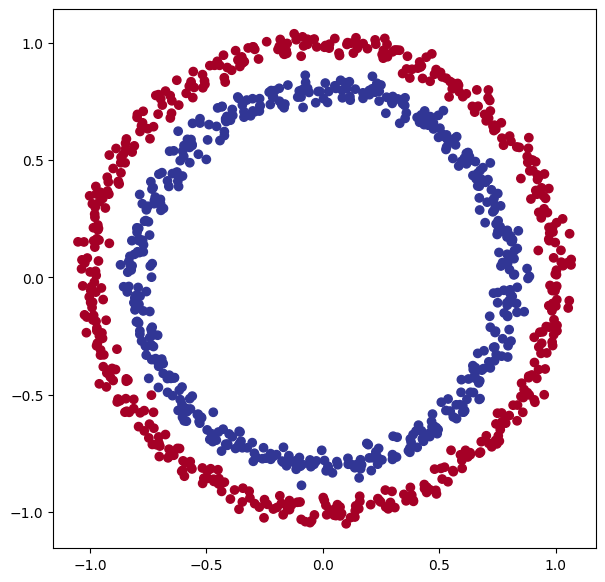

In [96]:
# Plot the data
plt.figure(figsize=(7,7))
plt.scatter(x=X[:,0], y=X[:,1], c=y, cmap=plt.cm.RdYlBu)

In [97]:
# Split the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED
                                                    )
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [98]:
X_train[:5], y_train[:5]

(array([[-0.09295993,  0.94242379],
        [-0.36055202, -0.71322977],
        [ 0.79332777, -0.16642497],
        [-0.84704188,  0.57131533],
        [ 0.70971741,  0.76499533]]),
 array([0, 1, 1, 0, 0]))

In [99]:
# Convert to tensor and move them to device
X_train, y_train = torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.float32).to(device)
X_train[:5], y_train[:5]

(tensor([[-0.0930,  0.9424],
         [-0.3606, -0.7132],
         [ 0.7933, -0.1664],
         [-0.8470,  0.5713],
         [ 0.7097,  0.7650]], device='cuda:0'),
 tensor([0., 1., 1., 0., 0.], device='cuda:0'))

In [100]:
# Define the model and move to device
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=10),
    nn.ReLU(),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.4117,  0.2006],
                      [ 0.4372, -0.4725],
                      [-0.2043,  0.1682],
                      [ 0.6577, -0.3166],
                      [ 0.3416,  0.2740],
                      [-0.4789, -0.5140],
                      [-0.0283,  0.5837],
                      [ 0.4834, -0.3996],
                      [-0.4432, -0.7033],
                      [ 0.5327, -0.2885]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.6118,  0.5523,  0.1620, -0.5855,  0.0469, -0.2083,  0.2081, -0.2073,
                       0.2108, -0.0181], device='cuda:0')),
             ('2.weight',
              tensor([[-0.0747, -0.2665,  0.0402, -0.0388,  0.1799,  0.2976, -0.0208, -0.1535,
                        0.2473,  0.0455],
                      [-0.2436, -0.1796,  0.0075,  0.2934,  0.2905,  0.1640, -0.0825, -0.3139,
                        0.1095, -0.1530],
                      [-0.0745, -0.1783, -0.1627,  0.182

In [101]:
# Define the loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr = 0.12)

In [103]:
# Define the accurancy funtion
try:
  import torchmetrics
except:
  ! pip install torchmetrics --quiet
  import torchmetrics

acc_fn = torchmetrics.classification.BinaryAccuracy().to(device)
# acc_fn = torchmetrics.classification.MulticlassAccuracy(num_classes=2).to(device)
# acc_fn = torchmetrics.classification.MultilabelAccuracy(num_labels=5).to(device)


In [104]:
# Setup train and test loop
results ={
    "train_loss":[],
    "train_acc":[],
    "test_loss":[],
    "test_acc":[]
}

torch.manual_seed(37)
torch.cuda.manual_seed(37)

epochs = 1000

for epoch in range(epochs):
  # train
  model_0.train()
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = acc_fn(y_pred, y_train)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # test
  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

  test_loss = loss_fn(test_logits, y_test)
  test_acc = acc_fn(test_pred, y_test)

  # Save loss for later graphing
  results["train_loss"].append(loss.cpu().detach().numpy())
  results["train_acc"].append(acc.cpu().detach().numpy())
  results["test_loss"].append(test_loss.cpu().detach().numpy())
  results["test_acc"].append(test_acc.cpu().detach().numpy())

  # Output
  if epoch % 100 == 0:
    print(f"Epoch: {epoch:3n} | Loss: {loss:.5f}, Acc: {acc:.2%} | Test loss: {test_loss:.5f}, test acc: {test_acc:.2%}")



Epoch:   0 | Loss: 0.69170, Acc: 52.25% | Test loss: 0.69179, test acc: 54.00%
Epoch: 100 | Loss: 0.68957, Acc: 50.75% | Test loss: 0.69048, test acc: 46.50%
Epoch: 200 | Loss: 0.68710, Acc: 52.63% | Test loss: 0.68691, test acc: 53.50%
Epoch: 300 | Loss: 0.68330, Acc: 52.88% | Test loss: 0.68266, test acc: 54.50%
Epoch: 400 | Loss: 0.67693, Acc: 54.87% | Test loss: 0.67654, test acc: 56.00%
Epoch: 500 | Loss: 0.66413, Acc: 58.63% | Test loss: 0.66587, test acc: 59.00%
Epoch: 600 | Loss: 0.63899, Acc: 75.63% | Test loss: 0.64198, test acc: 75.00%
Epoch: 700 | Loss: 0.58750, Acc: 85.62% | Test loss: 0.59084, test acc: 86.50%
Epoch: 800 | Loss: 0.48375, Acc: 96.25% | Test loss: 0.48353, test acc: 94.00%
Epoch: 900 | Loss: 0.32029, Acc: 99.50% | Test loss: 0.31859, test acc: 98.50%


In [105]:
# Get the helper function file
import requests
from pathlib import Path

HELPER_URL = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"
HELPER_FILE_NAME = "helper_functions.py"

if Path(HELPER_FILE_NAME).is_file():
  print(f"Skipping download {HELPER_FILE_NAME} since it already exists.")
else:
  print(f"Downloading {HELPER_FILE_NAME}...")
  request = requests.get(HELPER_URL)
  with open(HELPER_FILE_NAME, "wb") as f:
    f.write(request.content)
  print(f"Finished downloading {HELPER_FILE_NAME}...")


Skipping download helper_functions.py since it already exists.


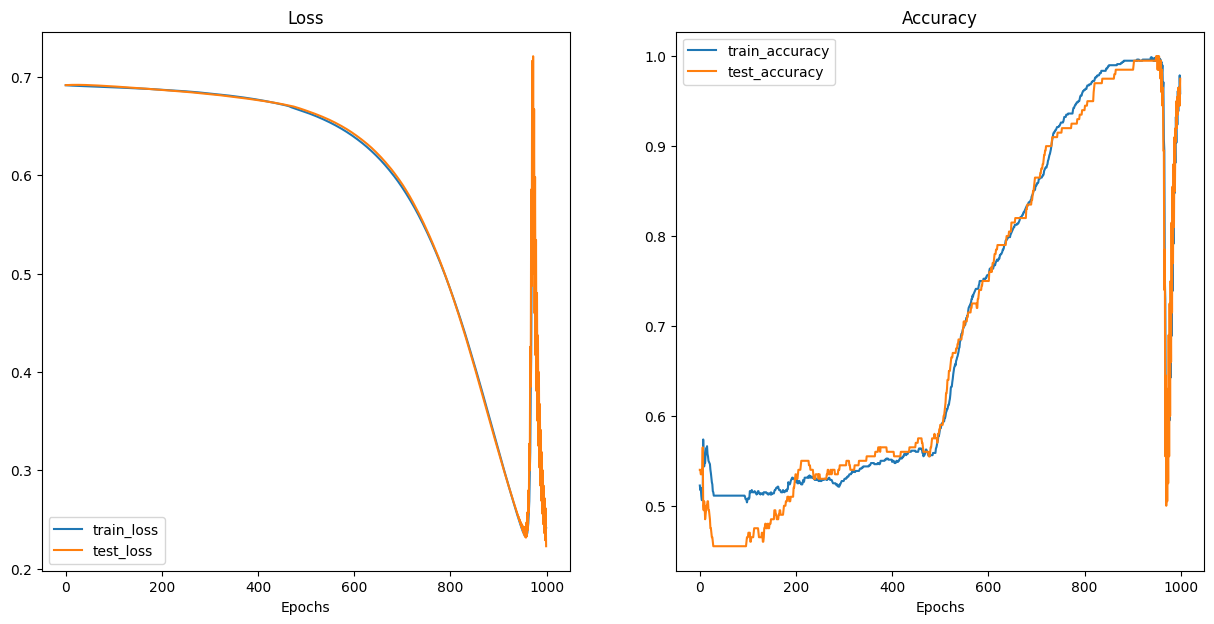

In [106]:
from helper_functions import plot_predictions, plot_loss_curves, plot_decision_boundary

# Plot Loss graph
plot_loss_curves(results)


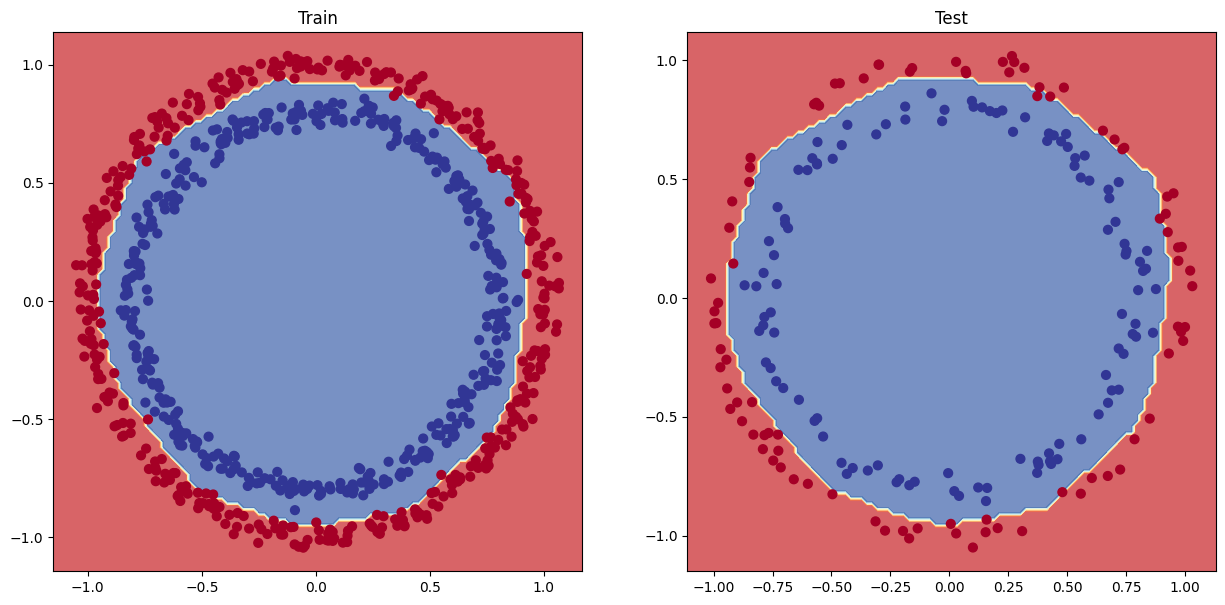

In [110]:
# Plot train and test result
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)
